<a href="https://colab.research.google.com/github/LimJongYoon/2020MLP/blob/master/04_ML_lesson3_planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-label prediction with Planet Amazon dataset

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai import *

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Getting the data

https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data
####kaggle API 사용


In [0]:
# pip3 install kaggle --upgrade [for MAC]
# 데이터 다운을 위한kaggle 다운로드

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [0]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [43]:
#path = Config.data_path()/'planet'
path = Path('./data/planet') #위에 코드 패스가 이상하게 설정되서 안됨 그래서 임의로 패스 설정해줌 
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('data/planet')

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [45]:
df = pd.read_csv(path/'train_v2_2m.csv') #잘된다
df.head()

#도저히 4만개의 파일을 읽지를 못해서 5천개로 수정해서 올렸다. (csv는 잘되는데 jpg가서 컴퓨터가 멈춰버림)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

**We** use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [0]:
np.random.seed(42) # train data 불러와서 
src = (ImageList.from_csv(path, 'train_v2_2m.csv', folder='train-jpg_5m', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))
#도저히 5천개도 안돌아가서 2천개로 ...

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

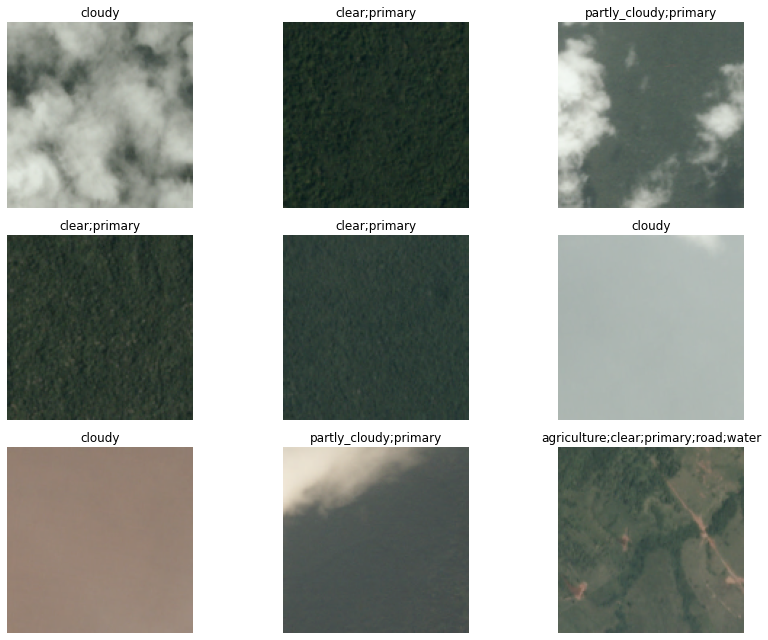

In [52]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [0]:
arch = models.resnet50

In [79]:
data.c

17

In [0]:
#accuracy_thresh(thresh=0.2)

In [54]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


We use the LR Finder to pick a good learning rate.

In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


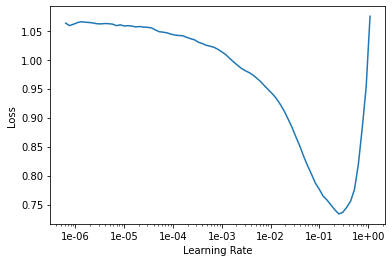

In [56]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [58]:
learn.fit_one_cycle(5, slice(lr))# 결과 0.883572

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.826281,0.498248,0.467492,0.555714,00:08
1,0.476235,0.164570,0.931446,0.868711,00:08
2,0.314173,0.141822,0.943093,0.879753,00:07
3,0.235997,0.135589,0.945894,0.888295,00:08
4,0.190233,0.133330,0.941177,0.883572,00:08


In [0]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


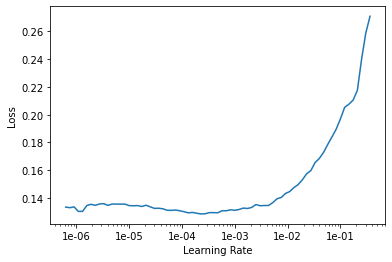

In [63]:
learn.lr_find()
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(5, slice(1e-5, lr/5)) #0.901378

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.128500,0.141890,0.938818,0.878067,00:08
1,0.128630,0.126643,0.939997,0.892786,00:08
2,0.120839,0.131905,0.946926,0.888638,00:08
3,0.109873,0.121219,0.947663,0.897001,00:08
4,0.099581,0.115877,0.950612,0.901378,00:08


In [0]:
learn.save('stage-2-rn50')

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


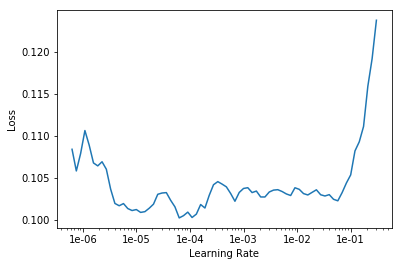

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [66]:
learn.fit_one_cycle(5, slice(lr))
 #0.904371 좋아진다

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085527,0.141369,0.944862,0.876310,00:08
1,0.120012,0.578944,0.926876,0.835561,00:08
2,0.125081,0.150002,0.943978,0.888158,00:08
3,0.114269,0.119280,0.947516,0.895801,00:08
4,0.105005,0.112815,0.950317,0.904371,00:08


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [69]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))  

#최종 0.910315 아무래도 데이터 수를 줄여서 정확도가 0.01-0.02 정도낮은듯?

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.089443,0.111436,0.950612,0.905656,00:08
1,0.087961,0.119189,0.951496,0.901700,00:08
2,0.085702,0.114018,0.953413,0.901583,00:08
3,0.083134,0.109009,0.951939,0.906158,00:08
4,0.075874,0.108761,0.950612,0.910315,00:08


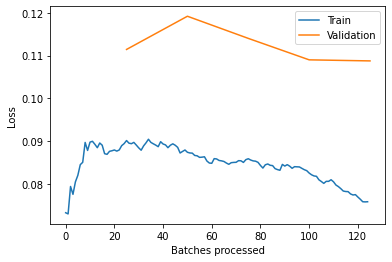

In [70]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [0]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [0]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [88]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

1

In [97]:
learn = load_learner(path, test=test)

#preds, _ = learn.get_preds(ds_type=DatasetType.Test)
#labels = np.argmax(preds, 1)
#배열 차원때문에 에러가 나는것 같은데 강의에서 안다루고 있어서 일단 part2로 넘어간다.
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss = True)
y = torch.argmax(preds,dim=1)

IndexError: ignored

In [86]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

NameError: ignored

In [94]:
labelled_preds[:5]

NameError: ignored

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)